# Visualizing Feature Maps

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from keras.models import Model, Sequential, load_model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.preprocessing import image
from matplotlib import pyplot
from numpy import expand_dims
from glob import glob

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# 특정 layer를 지나간 이미지 1개 출력 

In [ ]:
def image_visualization(image_path):
  
  img_path = image_path
  img = image.load_img(img_path, target_size = (150,150))
  plt.imshow(img)
  plt.axis('off')

  return plt.show()
  # 이미지 시각화 

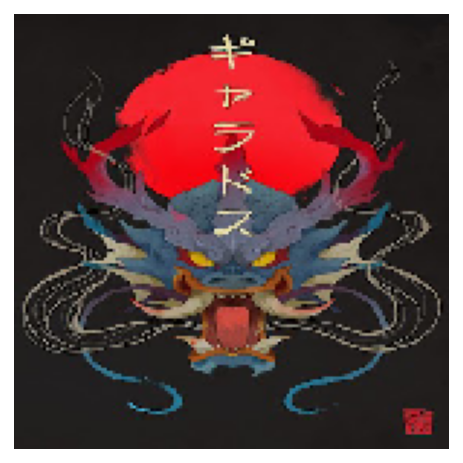

In [ ]:
image_visualization('/content/unnamed (5).jpg')

In [ ]:
def image_transform(image_path):

  img_path = image_path
  img = image.load_img(img_path, target_size=(150,150)) # 사이즈 고정 
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0) # 이미지가 여러장의 리스트로 구성되어 있으면 사용하지 않아도 됨 
  img_tensor /= 255.
  
  return img_tensor
  # 이미지 전처리 

In [ ]:
def visualization_one(arg, image, number):
  
  ''' 설명 
  arg : 특정 키워드(Conv or Pool)가 속한 Layer를 보고 싶을때 사용 
  image : 시각화하고자 하는 이미지의 path 
  number : 특정 키워드가 포함된 Layer의 깊이를 지칭(0부터 시작하며 숫자가 깊어질수록 추상적으로 변화)
  '''

  img_tensor = image_transform(image)

  layer_outputs = [layer.output for layer in vgg.layers if arg in layer.name]
  # arg에 속한 가진 layer 모두 도출 
  activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
  # 모델 지정 
  intermediate_activations = activation_model.predict(img_tensor)
  # 해당 이미지를 통해 결과 추출 
  first_layer_activation = intermediate_activations[number]
  # 숫자는 arg가 포함된 Layer를 뜻하며 숫자가 커질수록 깊은 Layer를 뜻하며 추상적으로 변함 

  plt.imshow(first_layer_activation[0, :, :, 1], cmap='viridis')
  # cmap는 https://matplotlib.org/stable/tutorials/colors/colormaps.html 참고하여 다르게 지정 가능 
  plt.axis('off')

  return plt.show()

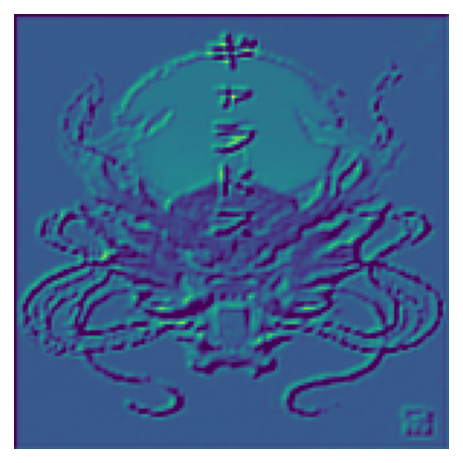

In [ ]:
visualization_one('conv2', '/content/unnamed (5).jpg', 0)

In [ ]:
def visualization(l_name, image, n_row, n_col):
  
  '''설명
  l_name : 시각화하고자 하는 Layer의 이름을 넣은 list 
  image : 시각화하고자 하는 이미지의 path 
  n_row, n_col : Layer마다 몇개의 이미지를 출력할지 결정할 수 있는 지표 
  '''

  img_tensor = image_transform(image)

  layer_names = l_name
  layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
  activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
  intermediate_activations = activation_model.predict(img_tensor)

  images_per_row, max_images = n_row, n_col
  # 몇개의 image output을 출력할것인지 결정 


  for layer_name, layer_activation in zip(layer_names, intermediate_activations):

      n_features = layer_activation.shape[-1]
      # layer output 개수 

      n_features = min(n_features, max_images)
      # output개수에서 지정한 개수만큼 output을 출력하기 위해 사용 

      size = layer_activation.shape[1]
      # 이미지 사이즈 추출 

      n_cols = n_features // images_per_row
      display_grid = np.zeros((size * n_cols, images_per_row * size))
      # 0으로 구성된 matrix 생성 여기에 값을 넣을 것 

      for col in range(n_cols):
          for row in range(images_per_row):
              channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
              # layer마다 도출되는 feature map이 각자 다름 
              # layer마다 predict된 몇개의 값만 도출

              channel_image -= channel_image.mean()
              channel_image /= channel_image.std()
              # 해당 값을 z값으로 바꿔줌 (x-mean) / std

              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              # channel_image의 값이 0보다 작으면 0으로 바꿔주고 255보다 크면 255로 바꿔줌 
              # 다시 이미지로 돌아가기 위해서 해당 작업 진행 
              display_grid[col * size : (col + 1) * size,
                          row * size : (row + 1) * size] = channel_image
              # 저장해놓은 0행렬에 해당 값들을 넣어줌 

      # 시각화 
      scale = 3. / size
      
      plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
      plt.axis('off')
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')
      # plt.colorbar()
  return plt.show()

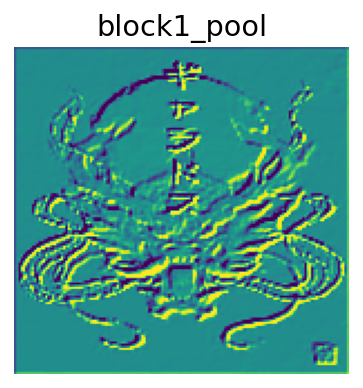

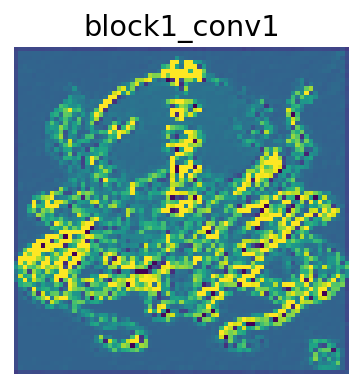

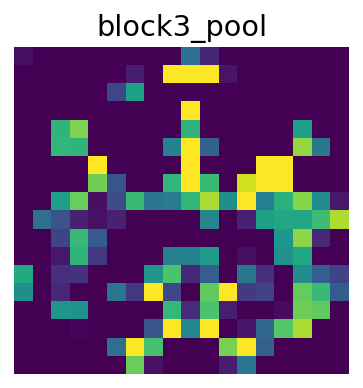

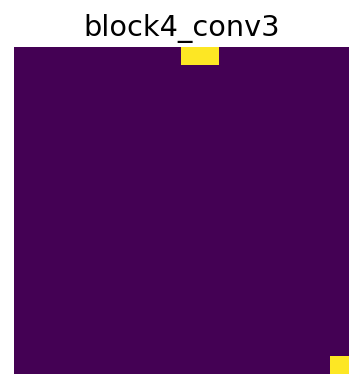

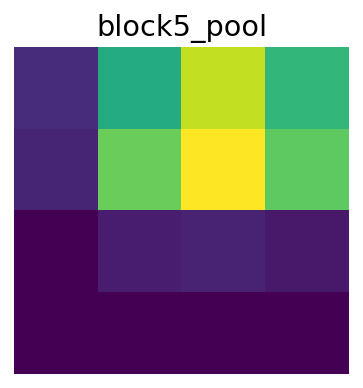

In [ ]:
layer = ['block1_pool', 'block1_conv1', 'block3_pool', 'block4_conv3', 'block5_pool']
visualization(layer, '/content/unnamed (5).jpg', 1, 1)